In [1]:
import torch
import torchvision
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

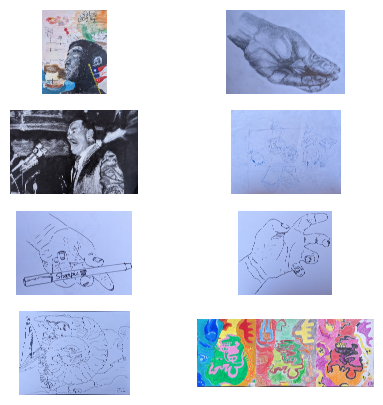

In [3]:
style_dir = "data/style"
photo_dir = "data/photo_jpg"
fig, axes = plt.subplots(4, 2, figsize=(5, 5))
ax = axes.flatten()

for i, file in enumerate(os.listdir(style_dir)):
    img = Image.open(os.path.join(style_dir, file))
    ax[i].imshow(img)
    ax[i].axis('off')

In [4]:
from torch.utils.data import DataLoader, Dataset

class StyleDataset(Dataset):
    def __init__(self, photo_dir, style_dir, transform = None):
        self.transform = transform
        self.root = style_dir
        self.photo_paths = os.listdir(photo_dir)
        self.photo_dir = photo_dir
        self.paths = os.listdir(style_dir)
        
    def __len__(self):
        return len(self.photo_paths)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root, self.paths[idx % 8]))
        photo_image = Image.open(os.path.join(self.photo_dir, self.photo_paths[idx]))
        if self.transform:
            image = self.transform(image)
            photo_image = self.transform(photo_image)
        return photo_image, image

In [5]:
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

In [6]:
dataset = DataLoader(StyleDataset(photo_dir, style_dir, transform=transforms), batch_size=32, shuffle=True)

In [7]:
class FastCycleGANGenerator(torch.nn.Module):
    def __init__(self, residual_blocks = 3):
        super().__init__()
        self.residual_blocks = residual_blocks
        self.convLayer = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(128),
        )
        self.residualBlock = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size = 5, stride = 1, padding = 2, bias = False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, kernel_size = 5, stride = 1, padding = 2, bias = False),
            torch.nn.BatchNorm2d(128)
        )
        self.upsamplingLayer = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.convLayer(x)
        for i in range(self.residual_blocks):
            skip = x
            x = self.residualBlock(x)
            x = torch.add(x, skip)
        x = self.upsamplingLayer(x)
        return x

In [8]:
class FastCycleGANDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convLayer = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace = True),
            torch.nn.Conv2d(128, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        )
        self.fcLayer = torch.nn.Sequential(
            torch.nn.Conv2d(128, 1, kernel_size = 4, stride = 2, padding = 1, bias = False),
            torch.nn.Flatten(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(inplace = True),
            torch.nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.convLayer(x)
        x = self.fcLayer(x)
        return x

In [9]:
gan_generator = FastCycleGANGenerator(1).to(device)
gan_discriminator = FastCycleGANDiscriminator().to(device)
optimizer_generator = torch.optim.RMSprop(gan_generator.parameters(), lr = 0.00003)
optimizer_discriminator = torch.optim.RMSprop(gan_discriminator.parameters(), lr = 0.00005)

In [ ]:
one = torch.FloatTensor([1]).to(device)
mone = one * -1

def train(dataloader, generator, discriminator, optimizer_discrim, optimizer_gen, device, epoch, function = None):
    size = len(dataloader.dataset)
    generator.train()
    discriminator.train()
    train_correct = 0
    for batch, (x, y) in enumerate(dataloader):
        for p in discriminator.parameters():
            p.requires_grad = True
            
        discriminator.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = discriminator(y)
        real_loss = pred.mean(0)
        real_loss.backward(one)
        
        fake_imgs = generator(x)
        pred = discriminator((fake_imgs).detach())
        fake_loss = pred.mean(0)
        fake_loss.backward(mone)
        discrim_loss = real_loss - fake_loss
        optimizer_discrim.step()
        
        for p in discriminator.parameters():
            p.requires_grad = False
            p.data.clamp_(-0.01, 0.01)
            
        generator.zero_grad()
        pred = discriminator(fake_imgs)
        gen_loss = pred.mean(0).view(1)
        gen_loss.backward(one)
        optimizer_gen.step()
        if (epoch+1) % 1 == 0:
            if (batch % 32 == 0):
                gen_loss, discrim_loss, current = gen_loss.item(), (discrim_loss).item(), (batch + 1) * len(x)
                
                print(f"Generator Loss: {gen_loss:>5f}\nDiscriminator Loss: {discrim_loss:>5f}  [{current:>3d}/{size:>3d}]")
                n_cols = 8
                n_rows = 4
                plt.figure(figsize = (n_cols, n_rows))
                for index, image in enumerate((fake_imgs).cpu().detach().numpy()):
                    plt.subplot(n_rows, n_cols, index + 1)
                    plt.imshow(image.transpose(1, 2, 0))
                    plt.axis("off")
                plt.show()

In [ ]:
epochs = 10
for epoch in range(epochs):
    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}\n-------------------------------")
    train(dataset, gan_generator, gan_discriminator, optimizer_discriminator, optimizer_generator, device, epoch)

In [ ]:
#torch.save(gan_generator.state_dict(), "model params/best_gen")
#torch.save(gan_discriminator.state_dict(), "model params/best_discrim")

In [10]:
gan_generator.load_state_dict(torch.load("model params/best_gen"))
gan_discriminator.load_state_dict(torch.load("model params/best_discrim"))

<All keys matched successfully>

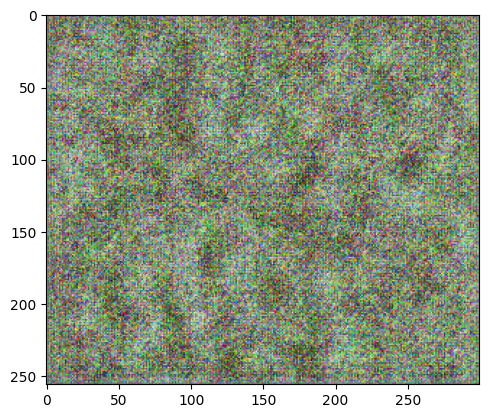

In [11]:
plt.imshow(gan_generator(torch.randn(1, 3, 256, 300).to(device)).squeeze().cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
video = cv2.VideoCapture(0)
video.set(3, 256)
video.set(4, 256)
video.set(cv2.CAP_PROP_FPS, 36)

preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
#only enable human detection, get rid of all other classes
model.classes = [0]

In [ ]:
if not video.isOpened():
    print("Camera not opened")

with torch.no_grad():
    while True:
        _, frame = video.read()
        
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model(img)
        bbox = results.xyxy[0].tolist()
        if bbox != []:
            bbox = results.xyxy[0].tolist()[0]
            x_min = int(bbox[0])
            y_min = int(bbox[1])
            x_max = int(bbox[2])
            y_max = int(bbox[3])
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            prediction = gan_generator((torch.tensor(frame[y_min:y_max, x_min:x_max]) / 255.0).movedim(-1, 0).unsqueeze(0).float().to(device)).cpu().squeeze().movedim(0, -1)
            difference_x = (x_max - x_min) - prediction.shape[1]
            difference_y = (y_max - y_min) - prediction.shape[0]
            frame[y_min:y_max - difference_y, x_min:x_max - difference_x] = prediction * 255
        cv2.imshow('YOLO V8 Detection', frame)     
        if cv2.waitKey(1) & 0xFF == ord(' '):
            break
    
video.release()
cv2.destroyAllWindows()